# MSDS 430 Final Project

### Project Objective

The goal of this project is to find the relationship between traffic collisions in Los Angeles City and victim's age, sex, and ethnicity, as well as geographic location and time.

### 1. Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ast

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import folium
from folium import plugins
from folium.plugins import MarkerCluster
from area import area

%matplotlib inline

pd.set_option('display.max_columns', 500) #expand the number of columns when displaying data

# data source: https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data
df = pd.read_csv('traffic-collision-data-from-2010-to-present.csv',converters={'Time Occurred': lambda x: str(x)}) #converters keeps the leading zero in Time Occurred field



In [2]:
df.shape

(467481, 24)

### 2. Data Cleaning & Manipulation

In [3]:
# Change Date Reported & Date Occurred to datetime object
df['Date Reported'] = pd.to_datetime(df['Date Reported'], format="%Y-%m-%d") 
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'], format="%Y-%m-%d") 

# Change Time Occurred to time object
df['Time Occurred'] = pd.to_datetime(df['Time Occurred'], format="%H%M").dt.time 

# Only keep records after 2017
df = df[df['Date Occurred'] >= '2017-01-01'] 

# Filter Victim Sex to valide values; F = femail, M = Male, X = Unknown
df = df[df['Victim Sex'].isin(['F','M'])]

# Filter Victim Descent to valide values
df = df[df['Victim Descent'].isin(['A','B','C','D','F','G','H','I','J','K','L','O','P','S','U','V','W','X','Z'])] 

# Change Victim Descent to simplier categories: Asian, Black, White, Hispanic, Other
#Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican 
#I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan 
#U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian
simple_descent = {'A' : 'Asian','B' : 'Black','C' : 'Asian',
                  'D' : 'Asian','F' : 'Asian','G' : 'Other',
                  'H' : 'Hispanic','I' : 'Other','J' : 'Asian',
                  'K' : 'Asian','L' : 'Asian','O' : 'Other',
                  'P' : 'Other','S' : 'Other','U' : 'Other',
                  'V' : 'Asian','W' : 'White','X' : 'Other',
                  'Z' : 'Asian'}

df['Victim_Descent_Simple'] = df['Victim Descent'].map(simple_descent)


# Victim Age = 99 seems to be code for unknown age; filter Victim Age to valid age (0 to 98)
df = df[(df['Victim Age'] >= 0) & (df['Victim Age'] < 99)]

# Change Location field to dictionary and extract the longitude & latitude, then convert to numeric
df['Location'] = df['Location'].apply(lambda x: ast.literal_eval(x))
df['Longitude'] = pd.to_numeric(df['Location'].apply(lambda x: x['longitude']))
df['Latitude'] = pd.to_numeric(df['Location'].apply(lambda x: x['latitude']))

    
# Keep only columns needed for this project
keep_cols = ['Date Occurred','Time Occurred','Area ID','Area Name','Victim Age',
             'Victim Sex','Victim_Descent_Simple','Longitude','Latitude']
df = df[keep_cols]


# Drop NAs in the data
df = df.dropna()

# Change column names containing space to underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

In [4]:
# Check dimension of the data
df.shape

(107844, 9)

In [5]:
# Print the first 20 rows of the cleaned dataset
df.head(20)

,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Victim_Age,Victim_Sex,Victim_Descent_Simple,Longitude,Latitude
0,2019-04-27,09:40:00,21,Topanga,26.0,F,White,-118.5846,34.1837
1,2019-04-27,11:15:00,10,West Valley,61.0,M,Hispanic,-118.5273,34.1975
2,2019-04-27,09:00:00,16,Foothill,20.0,F,Hispanic,-118.4225,34.2579
3,2019-04-27,06:00:00,10,West Valley,29.0,F,Hispanic,-118.5557,34.2066
4,2019-04-27,09:45:00,10,West Valley,53.0,M,Hispanic,-118.5335,34.2012
6,2019-04-27,10:45:00,6,Hollywood,48.0,M,White,-118.3332,34.0907
7,2019-04-27,19:40:00,21,Topanga,48.0,F,White,-118.6458,34.2130
8,2019-04-27,11:40:00,14,Pacific,50.0,M,Asian,-118.4252,34.0183
9,2019-04-27,01:00:00,17,Devonshire,30.0,M,White,-118.4802,34.2700
10,2019-04-27,10:50:00,2,Rampart,21.0,M,Hispanic,-118.2811,34.0628


In [6]:
# df.describe()
# df.isna().sum()
# df[df.isnull().any(axis=1)]

### 3. Analysis

#### 3.1 Victim Age and Victim Sex

In [7]:
# Check Victim Age distribution (min, 25%, median, 75%, max)
df['Victim_Age'].describe()

count    107844.000000
mean         40.980110
std          14.720594
min          10.000000
25%          29.000000
50%          38.000000
75%          51.000000
max          98.000000
Name: Victim_Age, dtype: float64

/Users/jessychang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


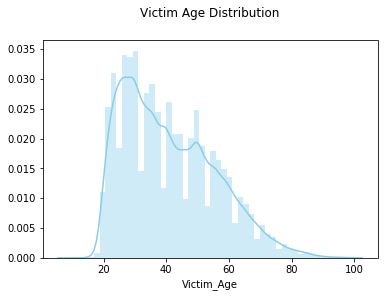

In [8]:
# Use histogram to check distribution of Victim Age
sns.distplot(df['Victim_Age'] , color="skyblue")

plt.title('Victim Age Distribution', y=1.08)
plt.show()

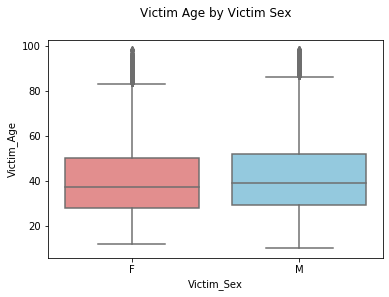

In [9]:
# Use boxplot to check distribution of Victim Age by Victim Sex
colors = ["lightcoral","skyblue",'lightgray']
sns.boxplot(x = df["Victim_Sex"], y = df["Victim_Age"], palette=colors)

plt.title('Victim Age by Victim Sex', y=1.08)
plt.show()

In [11]:
# Ordinary Least Squares (OLS) model (ANOVA) to test if the mean Victim Age between each Victim Sex group are different
model = ols('Victim_Age ~ C(Victim_Sex)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Victim_Sex),2.598720e+04,1.0,120.057152,6.358624e-28
Residual,2.334315e+07,107842.0,NaN,NaN


#### 3.2 Victim Descent

In [12]:
# Count how many traffic collision in Los Angeles group by victim descent
victim_descent = df.groupby([df['Victim_Descent_Simple']]).size()

# Sort values from large to small
victim_descent = victim_descent.sort_values(ascending=False)

In [13]:
pd.DataFrame(victim_descent, columns = ['Count'])

,Count
Victim_Descent_Simple,
Hispanic,45109
White,24302
Other,16445
Black,16092
Asian,5896


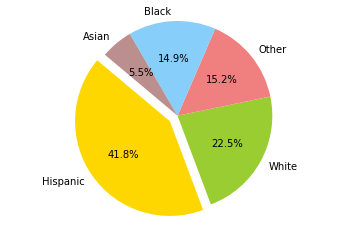

In [14]:
# Plot the victim descent in pie chart
labels = victim_descent.index
sizes = victim_descent
colors = ['gold','yellowgreen', 'lightcoral', 'lightskyblue','rosybrown']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')
plt.show()

#### 3.3 Traffic Collisions Occurred Date & Time

In [15]:
# Count how many traffic collision in Los Angeles group by Date Occurred Year
df.groupby([df['Date_Occurred'].dt.year]).size()

Date_Occurred
2017    47228
2018    47029
2019    13587
dtype: int64

In [16]:
# Count how many traffic collision in Los Angeles group by Date Occurred Year & Month
date_occurred = df.groupby([df['Date_Occurred'].dt.year, df['Date_Occurred'].dt.month]).size()
date_occurred

Date_Occurred  Date_Occurred
2017           1                3679
               2                3526
               3                4173
               4                3843
               5                3970
               6                3859
               7                3897
               8                4061
               9                3828
               10               4356
               11               3976
               12               4060
2018           1                3782
               2                3673
               3                4053
               4                3822
               5                3731
               6                3823
               7                4048
               8                4084
               9                3920
               10               4340
               11               3933
               12               3820
2019           1                3665
               2                3408
         

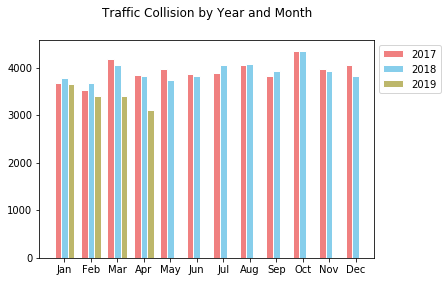

In [17]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = date_occurred.loc[2017,:]
bars2 = date_occurred.loc[2018,:]
bars3 = date_occurred.loc[2019,:]
 
# Set position of bar on X axis
r1 = date_occurred.loc[2017,:].index.get_level_values(1) 	# the month numbers
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2[:4]]

# Make the plot
plt.bar(r1, bars1, color='lightcoral', width=barWidth, edgecolor='white', label='2017')
plt.bar(r2, bars2, color='skyblue', width=barWidth, edgecolor='white', label='2018')
plt.bar(r3, bars3, color='darkkhaki', width=barWidth, edgecolor='white', label='2019')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(1,13)], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1)
plt.title('Traffic Collision by Year and Month', y=1.08)
plt.show()

In [18]:
# Check time (hour) distribution of traffic collision
hour = df['Time_Occurred'].apply(lambda x: x.hour)
hour.value_counts()

17    7735
18    7228
15    7072
16    6922
14    6652
13    6176
12    5899
19    5872
8     5581
11    5175
20    5049
10    4970
9     4945
7     4938
21    4488
22    3852
23    3260
6     2515
0     2362
1     1939
2     1862
5     1317
3     1120
4      915
Name: Time_Occurred, dtype: int64

/Users/jessychang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


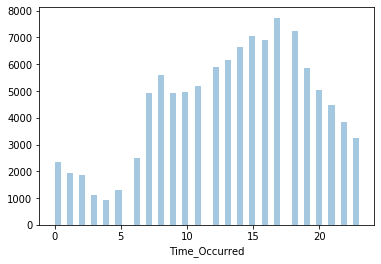

In [19]:
# Use seaborn to plot histogram of time
sns.distplot(a=hour, hist=True, kde=False, rug=False)

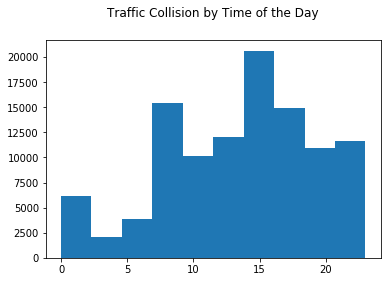

In [20]:
# Use matplotlib to plot histogram of time
plt.hist(hour) 
plt.title('Traffic Collision by Time of the Day', y=1.08)
plt.show()

#### 3.3 Traffic Collisions Occurred Locations

In [21]:
# Check traffic collisions by Area ID and Area Name
df.groupby(['Area_ID','Area_Name']).size()

Area_ID  Area_Name  
1        Central        4661
2        Rampart        3901
3        Southwest      6487
4        Hollenbeck     3895
5        Harbor         3599
6        Hollywood      4964
7        Wilshire       6329
8        West LA        5158
9        Van Nuys       5569
10       West Valley    5299
11       Northeast      4483
12       77th Street    7480
13       Newton         5965
14       Pacific        5633
15       N Hollywood    5453
16       Foothill       3726
17       Devonshire     5271
18       Southeast      4352
19       Mission        4853
20       Olympic        5802
21       Topanga        4964
dtype: int64

In [22]:
traffic_data = pd.DataFrame(df.groupby(['Area_ID']).size() ,columns=['Count'])
traffic_data = traffic_data.reset_index()
traffic_data['Area_ID'] = traffic_data['Area_ID'].astype(str)
# type(traffic_data)
traffic_data.head()

,Area_ID,Count
0,1,4661
1,2,3901
2,3,6487
3,4,3895
4,5,3599


In [23]:
# Import police stations location data
police_stations = pd.read_csv("LAPD_Police_Stations.csv")

In [24]:
police_stations.head()

,X,Y,OBJECTID,DIVISION,LOCATION,PREC
0,-118.289242,33.757661,1,HARBOR,2175 JOHN S. GIBSON BLVD.,5
1,-118.275394,33.938627,2,SOUTHEAST,145 W. 108TH ST.,18
2,-118.277670,33.970307,3,77TH STREET,7600 S. BROADWAY,12
3,-118.419842,33.991655,4,PACIFIC,12312 CULVER BLVD.,14
4,-118.305142,34.010575,5,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,3


In [25]:
# Set the location for Los Angeles City on foilum map
la_map = folium.Map(location =(34.0522, -118.2437),zoom_start=10)

In [26]:
# Plot on Choropleth map of traffic collision from every police station in every geographic area
la_map.choropleth(geo_data='lapd-divisions.geojson',
                  fill_color='YlOrRd', 
                  fill_opacity=0.5, 
                  line_opacity=1,
                  data = traffic_data,
                  columns = ['Area_ID','Count'],
                  key_on='feature.properties.external_id'
                 )

/Users/jessychang/anaconda3/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [27]:
# Plot blue popups to show the name of each geographic area and its total traffic collision counts
for index, police_station in police_stations.iterrows():
    police_station_location = [police_station[1],police_station[0]]
    division = police_station[3]
    counts = traffic_data[traffic_data['Area_ID'] == str(police_station[5])]['Count'].values[0]
    folium.Marker(location = police_station_location, popup = folium.Popup(html="Geographic Area: %s <br> Count of Traffic Collisions: %s" %(division,counts),max_width=450)).add_to(la_map)
              

In [28]:
la_map